In [4]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

2024-05-07 03:57:18.164368: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 03:57:18.230256: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found GPU at: /device:GPU:0


2024-05-07 03:57:22.292835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 15553 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:4f:00.0, compute capability: 8.9
2024-05-07 03:57:22.293975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:1 with 1802 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:52:00.0, compute capability: 8.9
2024-05-07 03:57:22.294748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:2 with 5220 MB memory:  -> device: 2, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:56:00.0, compute capability: 8.9
2024-05-07 03:57:22.295548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:3 with 6974 MB memory:  -> device: 3, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:57:00.0, compute capability: 8.9
2024-05-07 03:57:22.296229: I tensorflow/core/c

In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 8 GPU(s) available.
We will use the GPU: NVIDIA RTX 6000 Ada Generation


In [6]:
import torchvision
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import wandb
import opendatasets as od
from pathlib import Path
from collections import Counter
import splitfolders
from sklearn.metrics import precision_score,recall_score

In [7]:
dataset="https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone"
od.download(dataset)
data_path='ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
splitfolders.ratio(data_path, output='dataset',seed=831, ratio=(.8, 0.1,0.1))

Skipping, found downloaded files in "./ct-kidney-dataset-normal-cyst-tumor-and-stone" (use force=True to force download)


Copying files: 12446 files [02:00, 103.05 files/s]


In [21]:
height = 224
width = 244

trans=transforms.Compose([transforms.Resize((height,width)),
                          transforms.ToTensor(),
                          transforms.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
                         ])

In [22]:
batch_size = 32

train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
valid_dataset=datasets.ImageFolder(root="dataset/val",transform=trans)
test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [23]:
from torchvision import models
import torch.nn as nn

input_features = 4
classifier = models.alexnet(pretrained=True)
classifier.classifier[6] = nn.Linear(classifier.classifier[6].in_features, input_features)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '                Cyst,                Normal,                Normal,                Normal,                Normal,                Normal,                Normal,                 Tumor,                Normal,                Normal,                Normal,                 Stone,                 Tumor,                Normal,                 Stone,                  Cyst,                 Stone,                Normal,                Normal,                 Tumor,                 Stone,                 Tumor,                Normal,                  Cyst,                 Tumor,                Normal,                 Tumor,                  Cyst,                Normal,                 Stone,                 Tumor,                Normal, ')

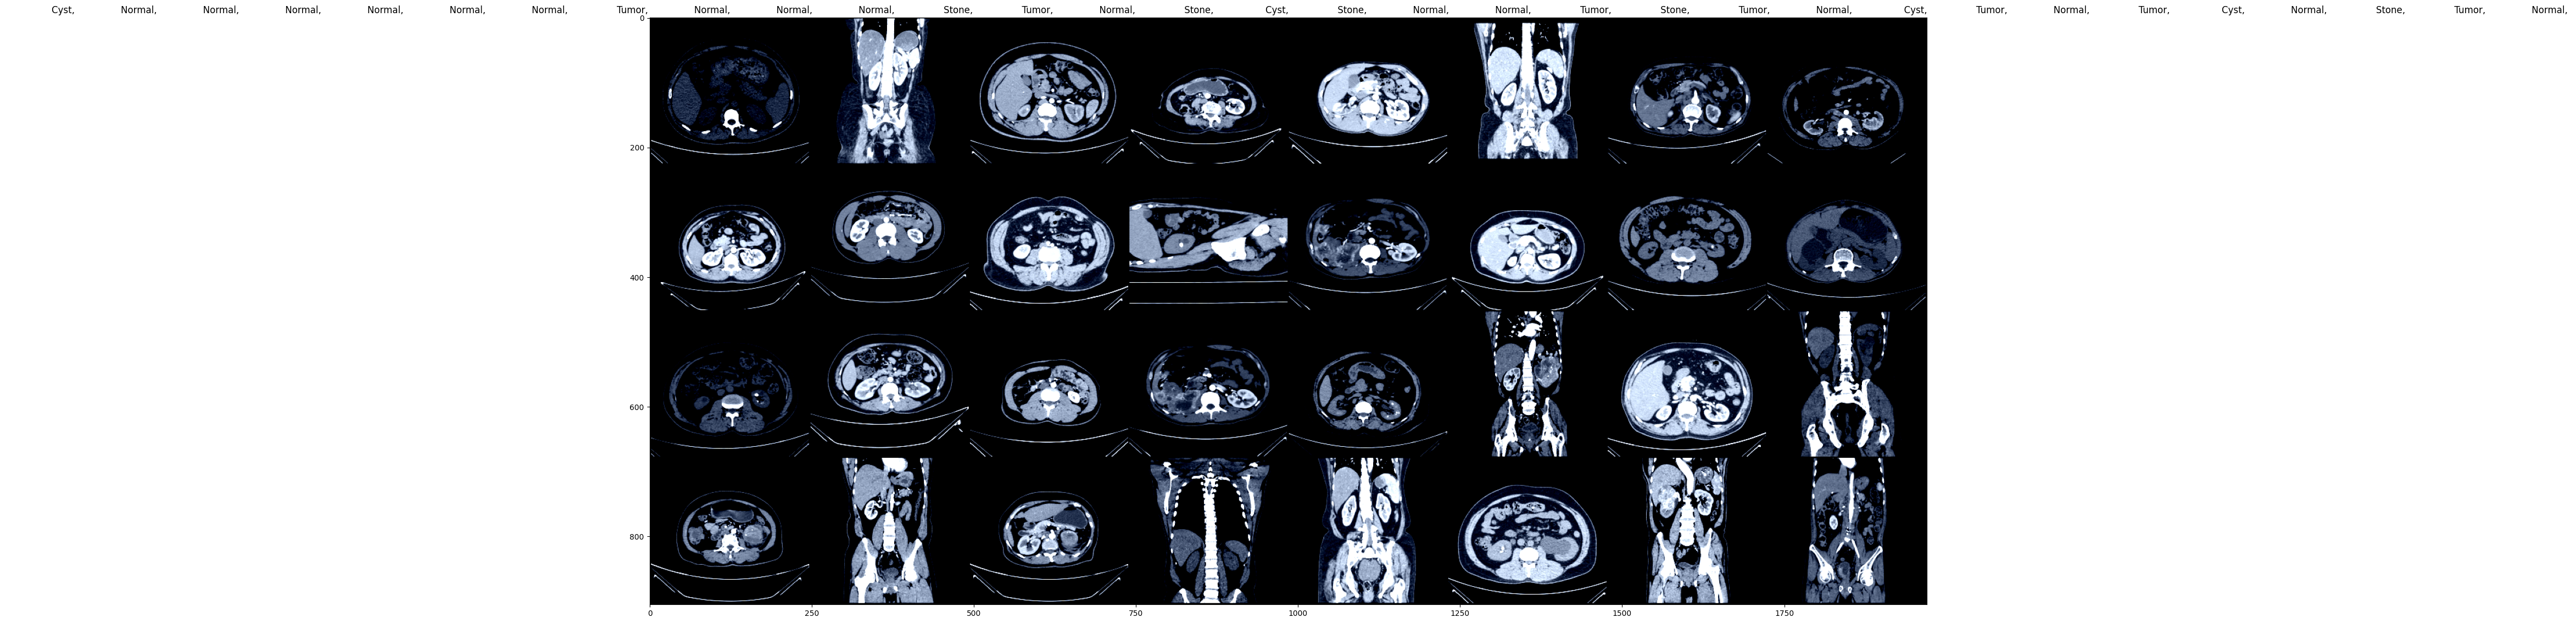

In [24]:
classes=(train_dataset.classes)
train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
fig = plt.figure(figsize=(30, 30))

images,labels=next(iter(train_loader))
img = images / 2 + 0.5 
grid_img = torchvision.utils.make_grid(img)
plt.imshow(grid_img.permute(1, 2, 0),cmap='gray')
plt.title(' '.join('%20s, ' % classes[labels[j]] for j in range(len(labels))))

In [25]:
import pandas as pd

data=pd.read_csv('ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv')
category=np.unique(data['Class'])
category
id,count=np.unique(data['Class'],return_counts=True)
id,count

median=np.median(count)
class_weight=[]
for i in range(len(category)):
    print(f'{category[i]} : {median/count[i]}')
    class_weight.append(median/count[i])
class_weight=torch.FloatTensor(class_weight)

Cyst : 0.8077648961984363
Normal : 0.5901122710261966
Stone : 2.175744371822803
Tumor : 1.3123083661848445


In [26]:
def train_eval(run,optimizer,device,classifier,epochs,class_weight,train_loader,valid_loader,test_loader):
   
    wandb.watch(classifier, log='all')
    classifier.train()
    classifier=classifier.to(device)
    class_weight=class_weight.to(device)
    
    for epoch in tqdm(range(epochs)):
        train_total_loss=0.0
        num_batch=0
        
        train_total_accuracy=0.0
        train_total=0
        for batch_size,(image,labels) in tqdm(enumerate(train_loader)):
           
            image=image.to(device)
            labels=labels.to(device)
            output=classifier(image)
            
            optimizer.zero_grad()
            loss=F.cross_entropy(output,labels,weight=class_weight)
            loss.backward()
            predicted=torch.argmax(output,dim=-1)
            
            optimizer.step()
            num_batch+=1
            train_total_loss+=loss.item()
            train_total+=len(labels)
           
            train_total_accuracy+=(predicted == labels).sum().item() 
            
        
        wandb.log({
        'average_train_loss': train_total_loss/num_batch,
        'average_train_accuracy' :train_total_accuracy/train_total    
            })
        classifier.eval()
        val_total_loss=0.0
        val_total_accuracy=0.0
        val_total_precision_considering_class=0.0
        val_total_recall_considering_class=0.0
        val_total=0
        num_batch=0
        
        with torch.no_grad():
            for image,labels in tqdm(valid_loader):
                
                image=image.to(device)
                labels=labels.to(device)
                output=classifier(image)
                loss=F.cross_entropy(output,labels,weight=class_weight)
                
                _,predicted=torch.max(output,1)
                num_batch+=1
                val_total_loss+=loss.item()
                val_total_accuracy+=(predicted == labels).sum().item() 
                val_total_precision_considering_class+=precision_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
                val_total_recall_considering_class+=recall_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
               
                val_total+=len(labels)
           
            
           
            
            wandb.log({
            'average_val_loss': val_total_loss/num_batch,
            'average_val_accuracy' :val_total_accuracy/val_total,    
            'average_val_precsion' :val_total_precision_considering_class/num_batch,    
            'average_val_recall' :val_total_recall_considering_class/num_batch
       
        })
    with torch.no_grad():
        classifier.eval()
        test_total_loss=0.0
        test_total_accuracy=0.0
        test_total_precision_considering_class=0.0
        test_total_recall_considering_class=0.0
        test_total=0
        num_batch=0        
        for image,labels in tqdm(test_loader):
            
            image=image.to(device)
            labels=labels.to(device)
            output=classifier(image)
            loss=F.cross_entropy(output,labels,weight=class_weight)
            
            _,predicted=torch.max(output,1)
            num_batch+=1
            test_total_loss+=loss.item()
            test_total_accuracy+=(predicted == labels).sum().item() 
            test_total_precision_considering_class+=precision_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
            test_total_recall_considering_class+=recall_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted',zero_division=1)
           
            test_total+=len(labels)
                
    print(f'average_test_loss: {test_total_loss/num_batch}\naverage_test_accuracy :{test_total_accuracy/test_total}\naverage_test_precsion :{test_total_precision_considering_class/num_batch}\naverage_test_recall :{test_total_recall_considering_class/num_batch}')
    torch.save(classifier.state_dict(),'kidney_model.pt')
    artifact=wandb.Artifact('model',type='model')
    artifact.add_file('kidney_model.pt')
    run.log_artifact(artifact)  

In [27]:
sweep_config={
'name' : 'parameter_tuning',
'method': 'grid',
'metric': {'name': 'val_loss','goal' :'minimize'},
'parameters':{
    'learning_rate' :
     {'values': [10**-5,10**-3]},
    'epochs': 
    {'values':[1,5,10]}
    
    },
'early_terminate':{
'type': 'hyperband',
'min_iter': 3
}
}

In [28]:
batch_size = 32

def run_sweep(config=None):
    run=wandb.init(config=config)
    wandb_config=wandb.config
    loss=nn.CrossEntropyLoss(weight=class_weight)
    train_dataset=datasets.ImageFolder(root="dataset/train",transform=trans)
    valid_dataset=datasets.ImageFolder(root="dataset/val",transform=trans)
    test_dataset=datasets.ImageFolder(root="dataset/test",transform=trans)
    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    valid_loader=DataLoader(valid_dataset,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    optimizer=torch.optim.Adam(classifier.parameters(),lr=wandb_config.learning_rate)
    train_eval(run,optimizer,device,classifier,wandb_config.epochs,class_weight,train_loader,valid_loader,test_loader)

In [30]:
import os

os.environ["WANDB_NOTEBOOK_NAME"] = "alexnet.ipynb"
sweep_id=wandb.sweep(sweep_config,project='kidney_classification')
wandb.agent(sweep_id,run_sweep)
wandb.finish()

Create sweep with ID: mef1n51v
Sweep URL: https://wandb.ai/devinpenka/kidney_classification/sweeps/mef1n51v


wandb: Agent Starting Run: 97b68c92 with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 1e-05
